Importing basic libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import os
import seaborn as sns
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


# 1. Data Exploration

Select notebook's root directory and load .csv file

In [2]:
# This gets the current working directory (where the notebook is assumed to be running)
current_directory = os.getcwd()

# File path construct
file_path = os.path.join(current_directory, 'housing.csv')

# Use the file path with pandas
df = pd.read_csv(file_path)

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The dataset has 10 columns, of which 9 store a numerical data type, ocean_proximity being the exception.

Attributes:

longitude: Reflects the westward position of a property, with higher figures indicating further west.
latitude: Indicates the northward position of a property, with higher numbers showing further north.
housing_median_age: Represents the median age of households in a neighborhood, where smaller numbers signify newer structures.
total_rooms: The total amount of rooms in a neighborhood.
total_bedrooms: The total amount of bedrooms in a neighborhood.
population: The overall number of people in a neighborhood.
households: The count of households in a neighborhood.
median_income: The neighborhood's median earnings per household, expressed in tens of thousands of US Dollars.
ocean_proximity: The property's relative location to the ocean.

median_house_value (target value): The median value of homes in a neighborhood, expressed in US Dollars.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The column for total_rooms has 207 missing values.

In [5]:
df.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

In [6]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

The column ocean_proximity has 5 different values across the entire dataset ('<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'). The latter appears in only 5 records out of 20640. This can have a negative impact on the evaluation of predictive capabilities as the model will face potential challenges like overfitting. For that reason, we will try to normalize the data by changing 'categorical' data to numerical values.

## 1.1 Data Visualization

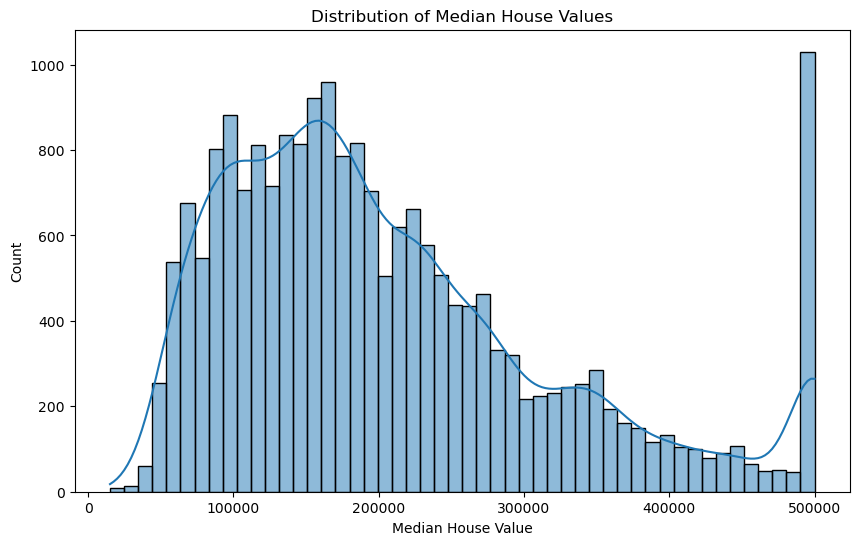

In [7]:
# Plot distribution of median_house_values
plt.figure(figsize=(10, 6))
sns.histplot(df['median_house_value'], bins=50, kde=True)
plt.title('Distribution of Median House Values')
plt.xlabel('Median House Value')
plt.ylabel('Count')
plt.show()

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

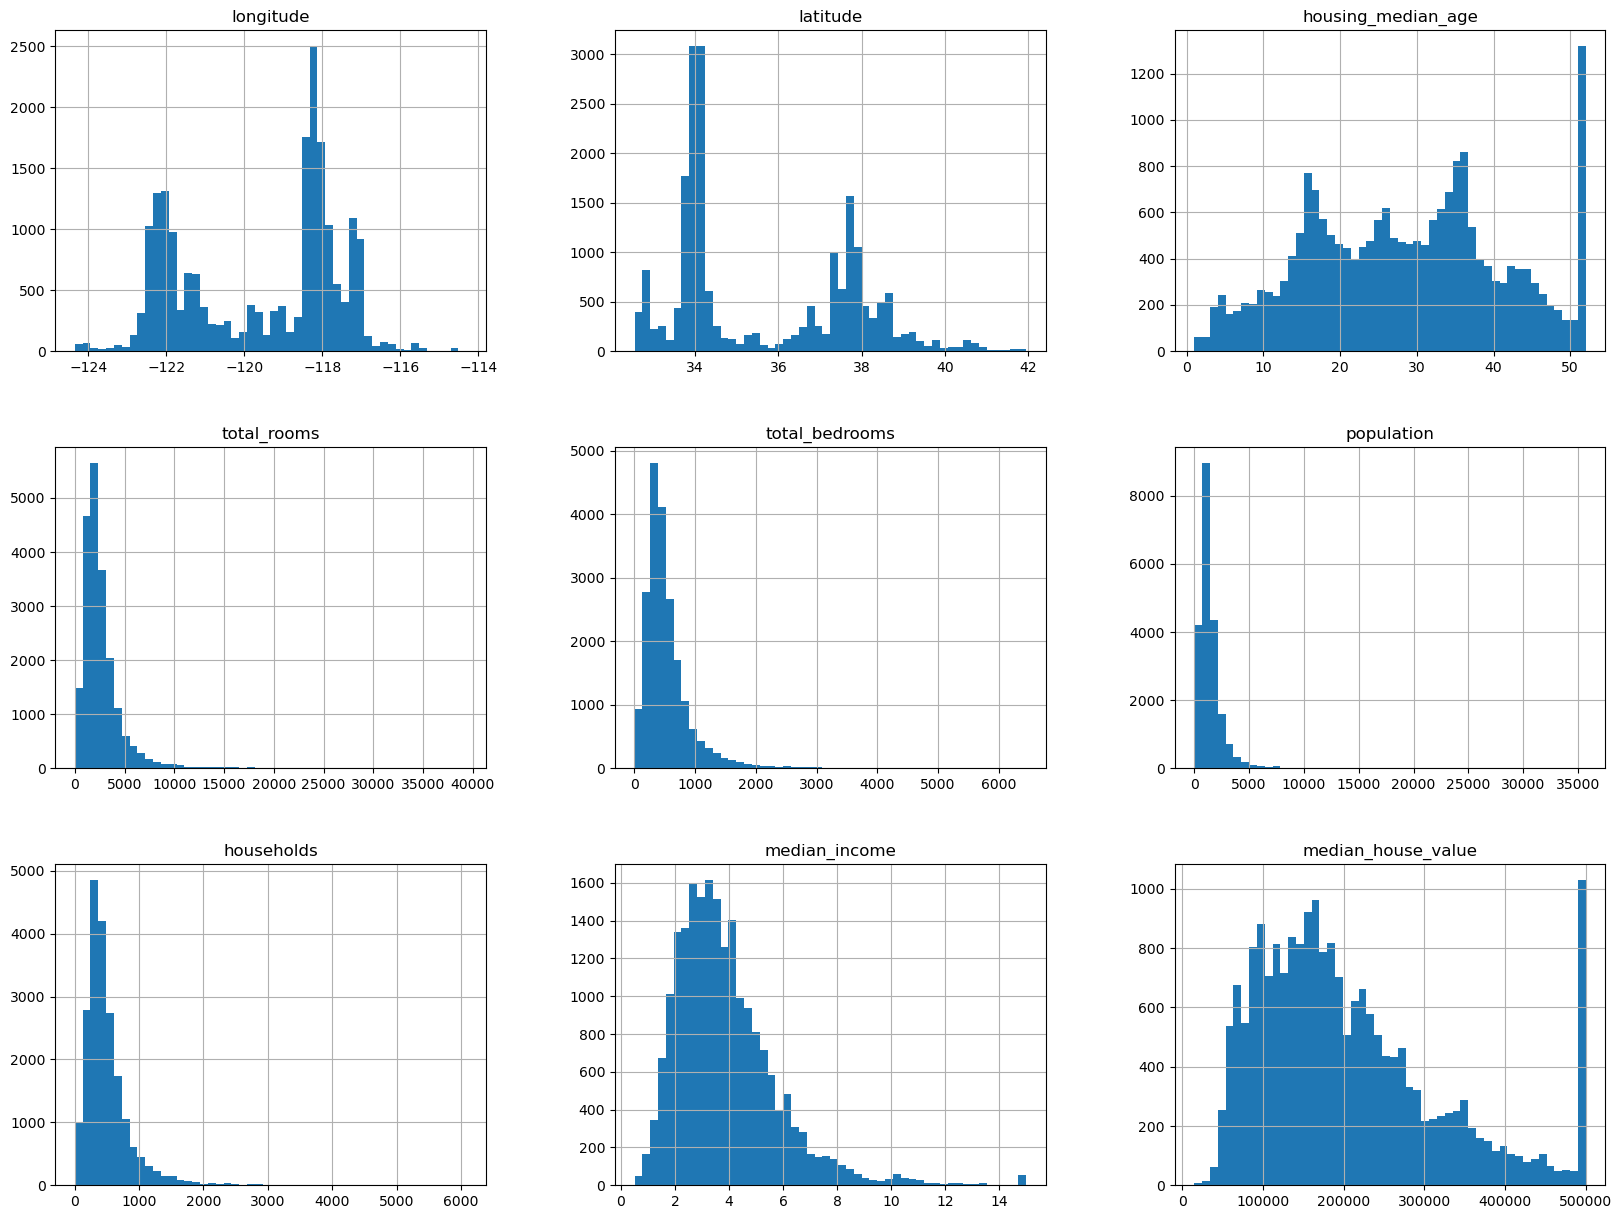

In [8]:
df.hist(bins=50, figsize=(20,15))

Notice skewness: total_bedrooms, total_rooms, population, households, median_income.

To see the correlation between attributes and median_house_value, we create a heatmap which will visually represent 
the correlation matrix, making it easier to identify potential relationships within the data.

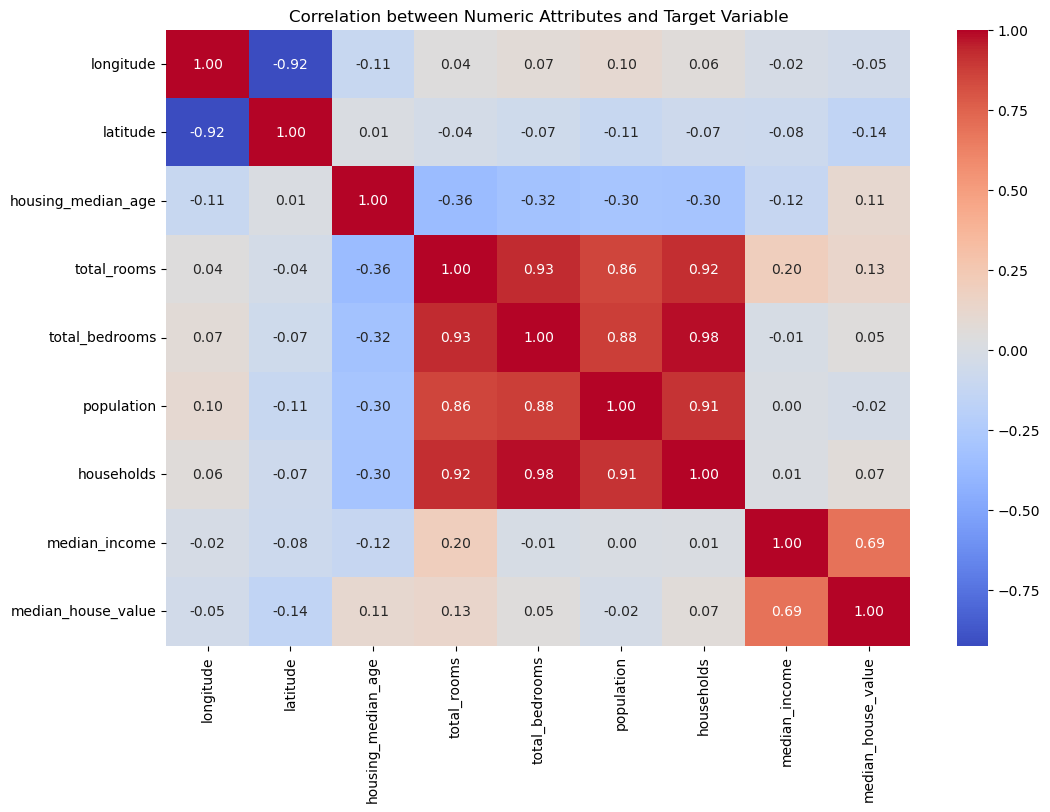

In [9]:
# Calculate the correlation matrix excluding non-numeric columns
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Numeric Attributes and Target Variable')
plt.show()


# 2. Data Preprocessing and Feature Engineering

In [10]:
# Imputing missing values from total_bedrooms column
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df['total_bedrooms'] = imputer.fit_transform(df[['total_bedrooms']])

In [11]:
# Checking for missing values
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [12]:
df.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

In [13]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Using get_dummies we split ocean_proximity column into 5 different columns that store the information in 'False' or 'True' values.

In [14]:
# Replace ocea_proximity column using get_dummies()
df = pd.get_dummies(data=df, columns=['ocean_proximity'])

In [15]:
# Checking ocean_proximity column change
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,False,True,False,False,False
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,False,True,False,False,False
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,False,True,False,False,False
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,False,True,False,False,False


Applying transformations (log, square root, etc.) can reduce the effect of outliers by bringing them closer to the rest of the data.

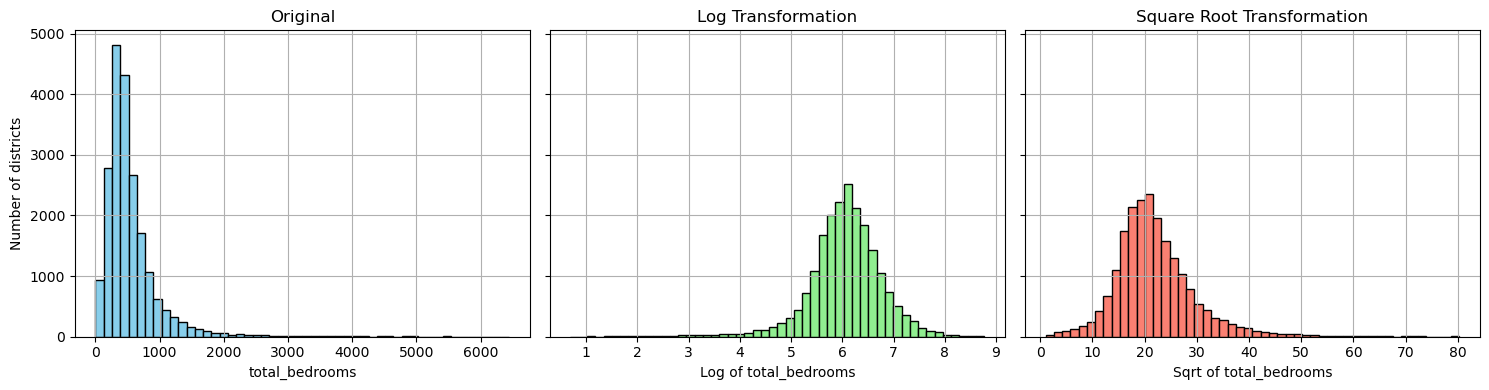

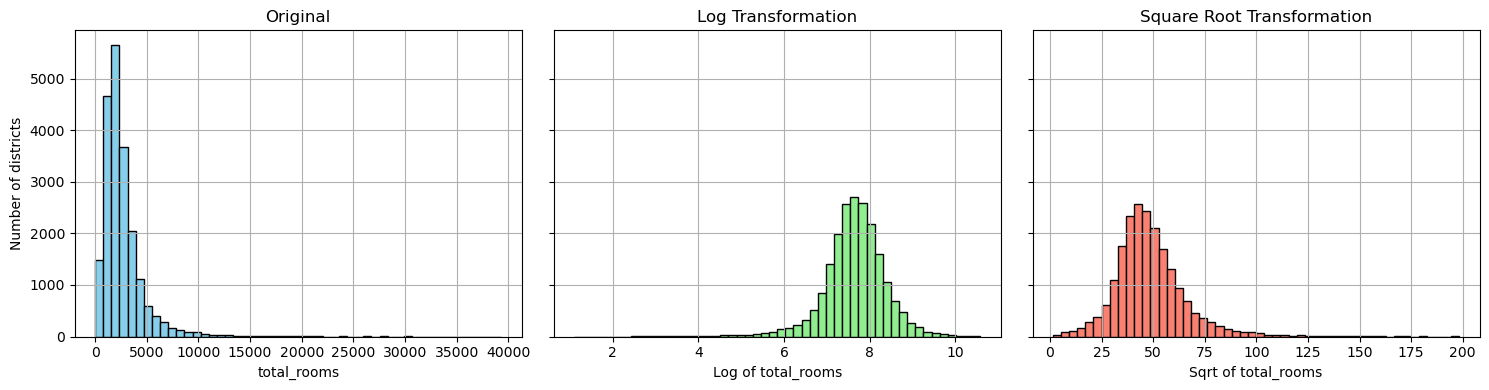

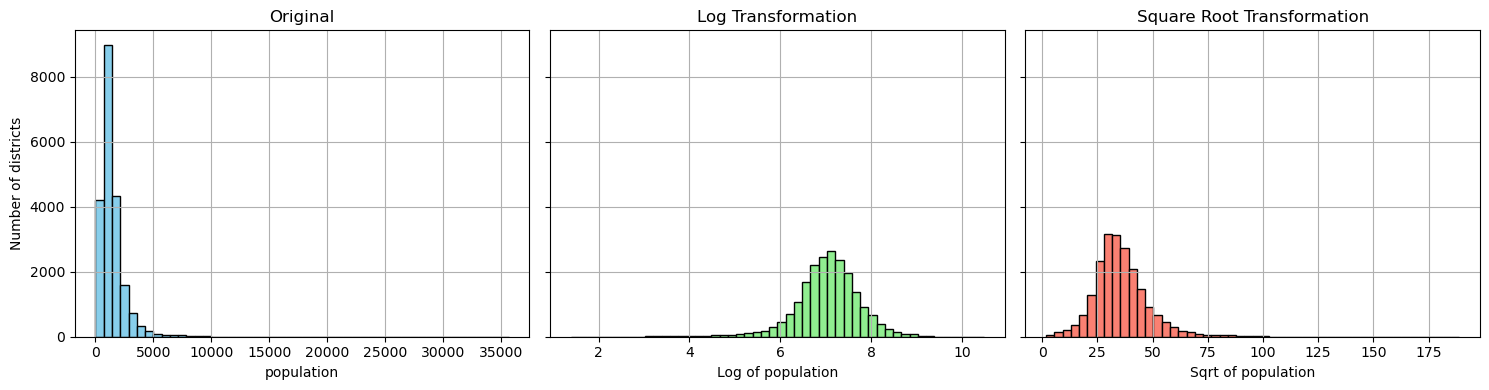

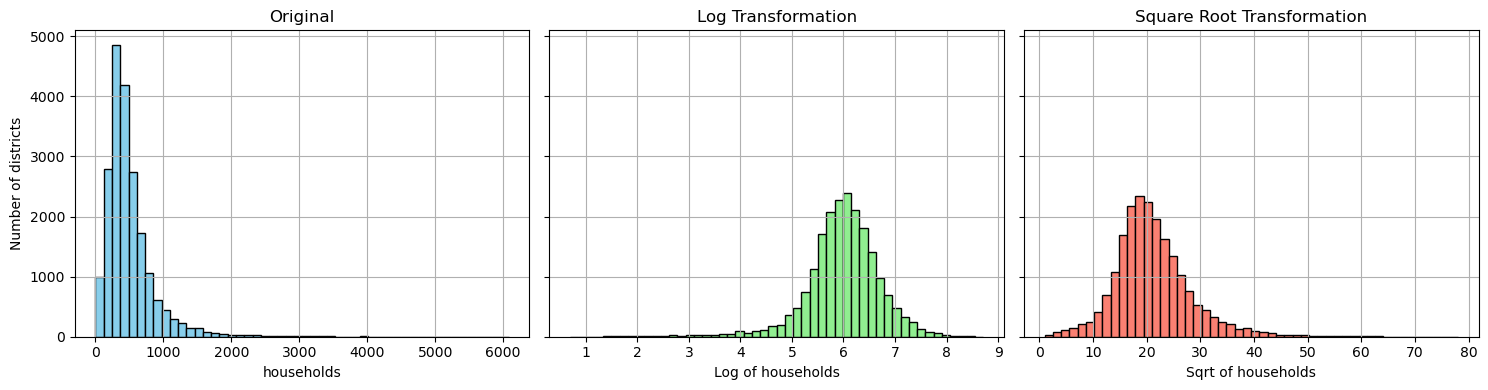

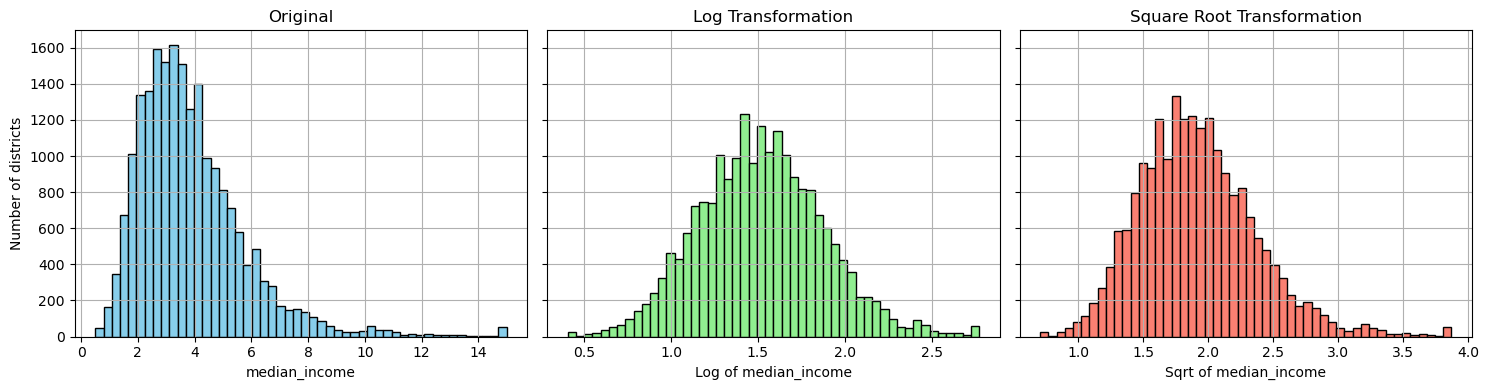

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transformations(data, column, bins=50):
    data_log = np.log(data[column] + 1)
    data_sqrt = np.sqrt(data[column])
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    
    data[column].hist(ax=axs[0], bins=bins, color='skyblue', edgecolor='black')
    axs[0].set_title('Original')
    axs[0].set_xlabel(column)
    axs[0].set_ylabel("Number of districts")
    
    data_log.hist(ax=axs[1], bins=bins, color='lightgreen', edgecolor='black')
    axs[1].set_title('Log Transformation')
    axs[1].set_xlabel(f"Log of {column}")
    
    data_sqrt.hist(ax=axs[2], bins=bins, color='salmon', edgecolor='black')
    axs[2].set_title('Square Root Transformation')
    axs[2].set_xlabel(f"Sqrt of {column}")
    
    plt.tight_layout()
    plt.show()

plot_transformations(df, "total_bedrooms")
plot_transformations(df, "total_rooms")
plot_transformations(df, "population")
plot_transformations(df, "households")
plot_transformations(df, "median_income")

In [17]:
def sqrt_transform(data, columns):
    data[columns] = data[columns].apply(np.sqrt)

def log_transform(data, columns):
    data[columns] = data[columns].apply(np.log)

sqrt_transform(df, ["total_bedrooms", "total_rooms", "households"])
log_transform(df, ["population", "median_income"])

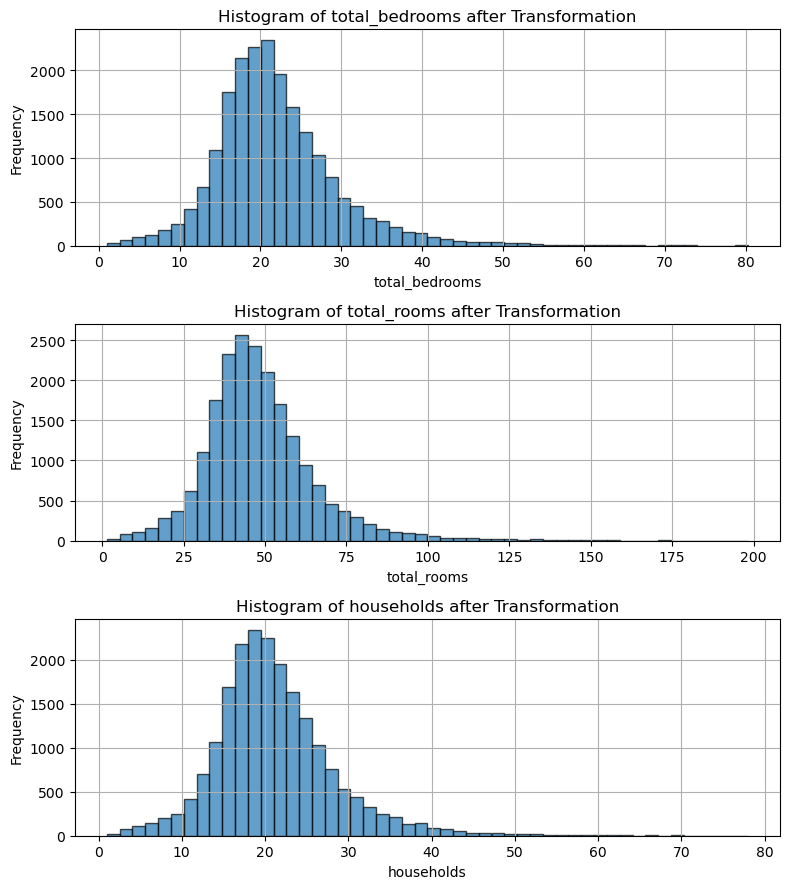

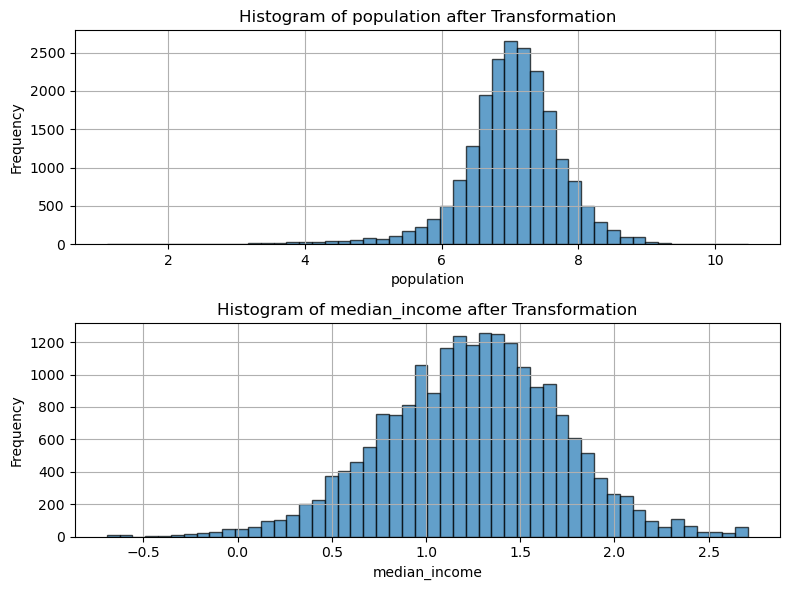

In [18]:
import matplotlib.pyplot as plt

# Function to plot histograms for the transformed columns
def plot_transformed_histograms(data, columns):
    fig, axs = plt.subplots(len(columns), 1, figsize=(8, 3 * len(columns)))
    
    # If there's only one column, axs might not be an array, so we wrap it in a list
    if len(columns) == 1:
        axs = [axs]
    
    for ax, column in zip(axs, columns):
        data[column].hist(ax=ax, bins=50, edgecolor='k', alpha=0.7)
        ax.set_title(f'Histogram of {column} after Transformation')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Names of the columns that have been transformed
sqrt_transformed_columns = ["total_bedrooms", "total_rooms", "households"]
log_transformed_columns = ["population", "median_income"]

# Plot histograms for sqrt transformed columns
plot_transformed_histograms(df, sqrt_transformed_columns)

# Plot histograms for log transformed columns
plot_transformed_histograms(df, log_transformed_columns)


Observe the changes in the data shown, log and sqrt transformation lead to a better data distribution.

In [19]:
# New columns - rooms per house, bedrooms ratio, people per household columns added
df['rooms_house'] = df['total_rooms']/df['households']
df['bedrooms_ratio'] = df['total_bedrooms']/df['total_rooms']
df['population_house']= df['population']/df['households']

OPTIONAL - not sure if the assignment allows me to remove the outliers on median_house_value but I believe this is just a modified version of the dataset in which the data was capped, the following code shows that a lot of records sit at it's max value in case of median_house_value AND housing_median_age, the histograms shows this clearly
NOTE - the RMSE score significantly improves on every model if the OPTIONAL code is ran and the outliers removed

<Axes: >

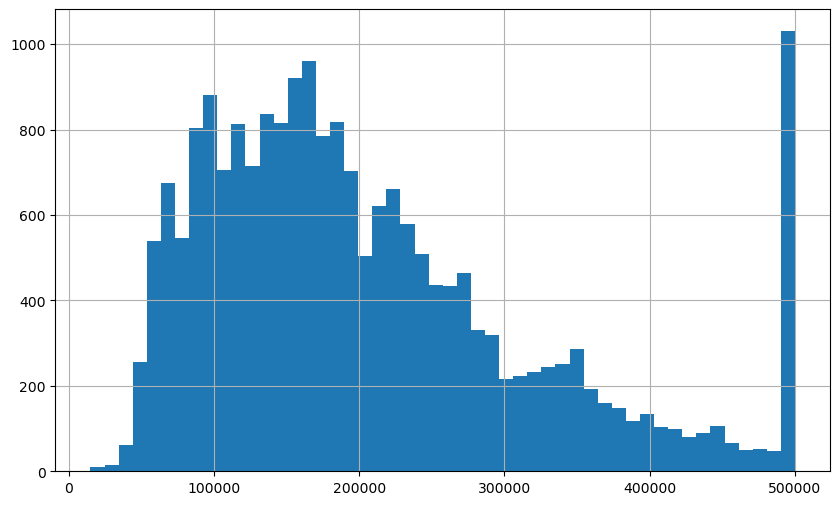

In [20]:
df['median_house_value'].hist(bins=50, figsize=(10, 6))

In [21]:
records_in_range = df[(df['median_house_value'] > 499000) & (df['median_house_value'] <= 500001)].shape[0]
print(records_in_range)
records_in_range = df[(df['median_house_value'] > 500000) & (df['median_house_value'] <= 500001)].shape[0]
print(records_in_range)

993
965


The 2 lines above show that there are 993 records with a house_median_value between 499000 and 500000, but 965 of them are set at the cap value of '500000'. Presumably the dataset wasn't meant to have such a high number of records so just out of curiosity I will try to remove these right outliers and see if the models will perform better.

In [22]:
df = df[df['median_house_value'] < 500000]

<Axes: >

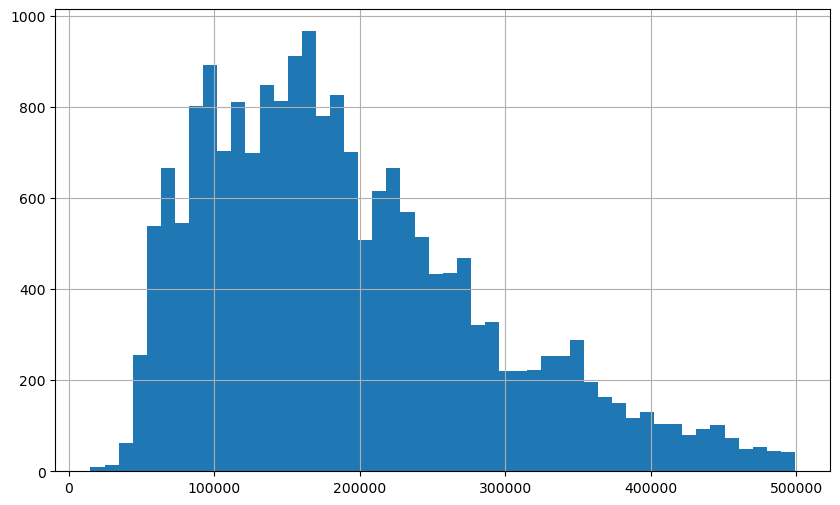

In [23]:
df['median_house_value'].hist(bins=50, figsize=(10, 6))

In [24]:
records_in_range = df[(df['housing_median_age'] > 50) & (df['housing_median_age'] <= 51)].shape[0]
print(records_in_range)
records_in_range = df[(df['housing_median_age'] > 51) & (df['housing_median_age'] <= 52)].shape[0]
print(records_in_range)

44
1093


<Axes: >

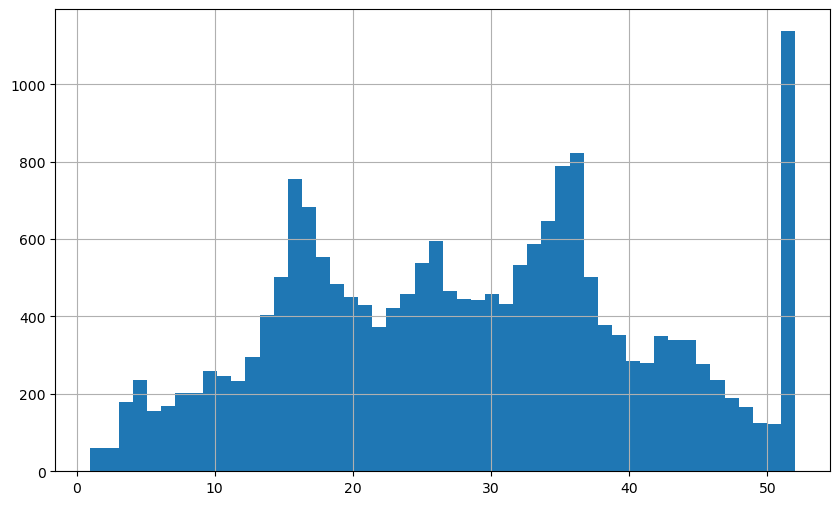

In [25]:
df['housing_median_age'].hist(bins=50, figsize=(10, 6))

In [26]:
df = df[df['housing_median_age'] < 52]

<Axes: >

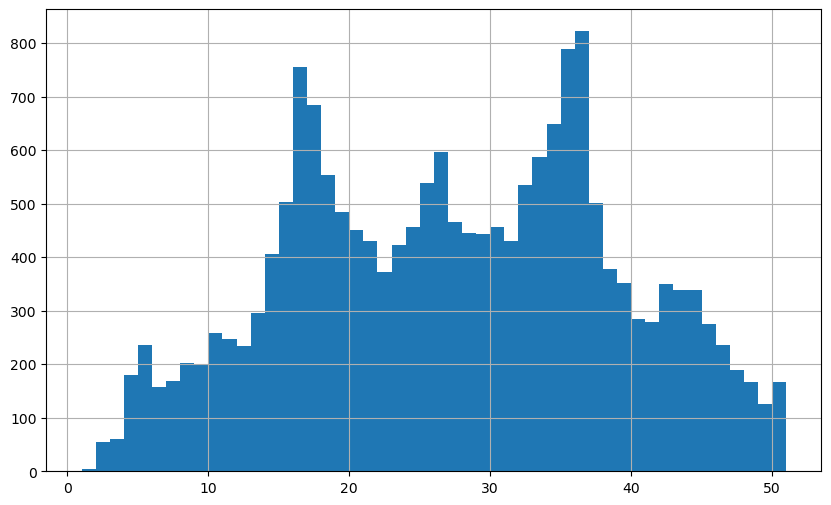

In [27]:
df['housing_median_age'].hist(bins=50, figsize=(10, 6))

END OF OPTIONAL

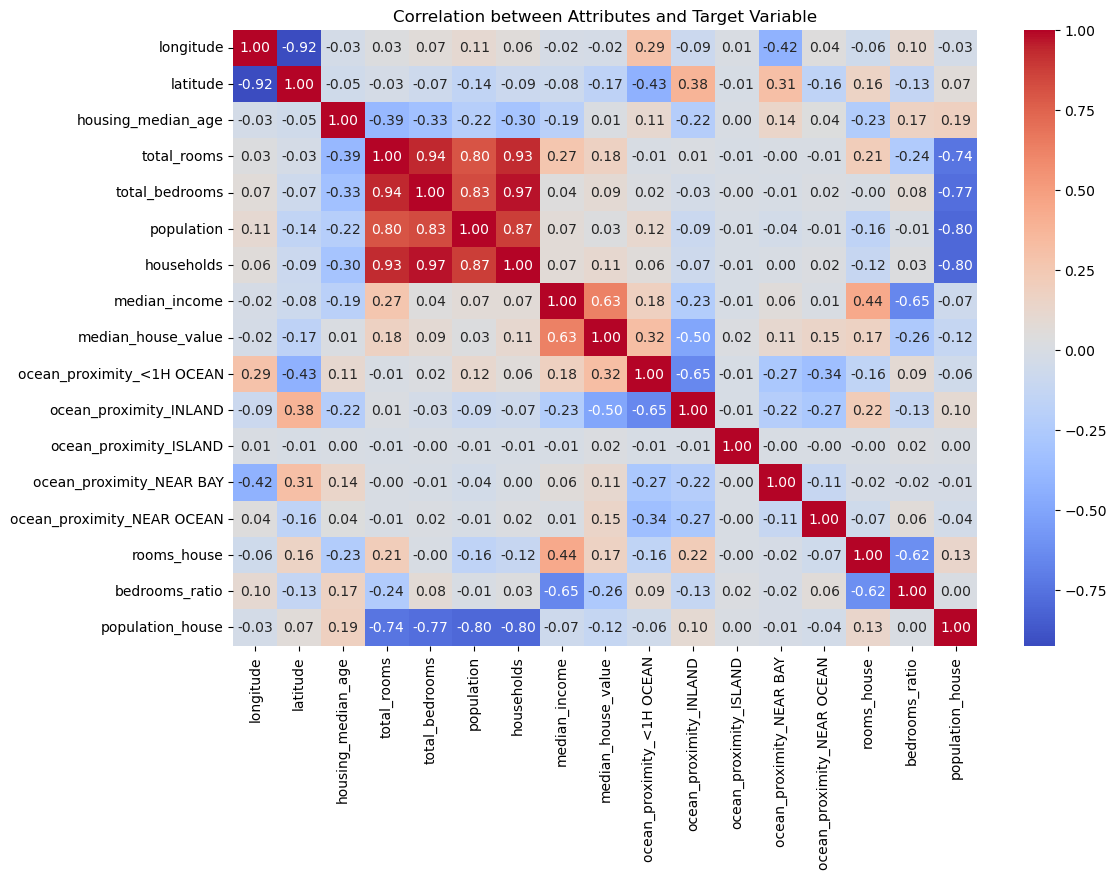

In [28]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Attributes and Target Variable')
plt.show()

After adding the extra columns seems like the target variable have developed correlations to them, rooms_house: which represents
rooms per house, has a value of 0.15. The other 2 have negative values although this might help non-linear models make better
predictions, so we will keep them.

In [29]:
correlations = df.corr()['median_house_value'].sort_values(ascending=False)

# Convert the correlation Series to a DataFrame for better visualization
correlations_table = correlations.to_frame().reset_index()
correlations_table.columns = ['Feature', 'Correlation with Median House Value']

print(correlations_table)

                       Feature  Correlation with Median House Value
0           median_house_value                             1.000000
1                median_income                             0.629483
2    ocean_proximity_<1H OCEAN                             0.317193
3                  total_rooms                             0.180726
4                  rooms_house                             0.167475
5   ocean_proximity_NEAR OCEAN                             0.147385
6                   households                             0.113482
7     ocean_proximity_NEAR BAY                             0.111744
8               total_bedrooms                             0.088617
9                   population                             0.029117
10      ocean_proximity_ISLAND                             0.019534
11          housing_median_age                             0.014121
12                   longitude                            -0.022901
13            population_house                  

# 3. Model Selection and Implementation

## Linear Regression Baseline Model

In [30]:
from sklearn.model_selection import train_test_split

x = df.drop('median_house_value', axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
df_train = X_train.join(y_train)

X_train, y_train = df_train.drop('median_house_value', axis=1), df_train['median_house_value']

df_test = X_test.join(y_test)
X_test, y_test = df_test.drop('median_house_value', axis=1), df_test['median_house_value']

In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-create DataFrame for X_test if needed for column operations (e.g., renaming)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [32]:
from sklearn.linear_model import LinearRegression

# Linear Regression Model
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

LinearRegression()

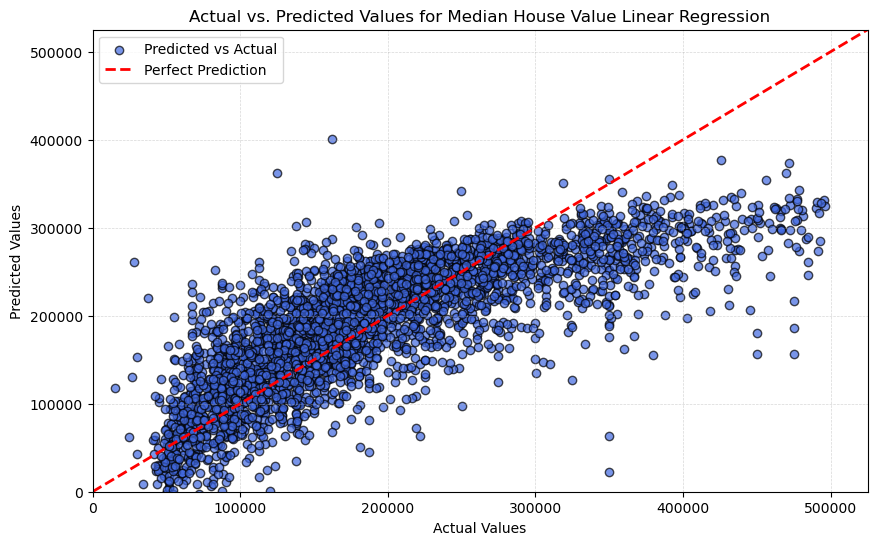

In [33]:
# Predict and evaluate
y_pred_lr = reg.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7, edgecolor='k', color='royalblue', label='Predicted vs Actual')

# Axis labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Median House Value Linear Regression')

# Adjusting the minimum and maximum values for plotting
min_val = max(min(min(y_test), min(y_pred_lr)), 0)
max_val = 525000  # Setting the upper limit as requested

# Axes limits
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

# Perfect prediction line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# Adding a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Legend
plt.legend()

plt.savefig('linear_regression_performance.png', dpi=300, bbox_inches='tight')

plt.show()

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

r2_linear_regression = reg.score(X_test_scaled, y_test)
print("R2 for Linear Regression:", r2_linear_regression)
mse_linear_regression = mean_squared_error(y_test, y_pred_lr)
print("MSE for Linear Regression:", mse_linear_regression)
rmse_linear_regression = np.sqrt(mse_linear_regression)
print("RMSE for Linear Regression:", rmse_linear_regression)
mae_linear_regression = mean_absolute_error(y_test, y_pred_lr)
print("MAE for Linear Regression:", mae_linear_regression)

R2 for Linear Regression: 0.608718633012456
MSE for Linear Regression: 3594199520.569763
RMSE for Linear Regression: 59951.64318490164
MAE for Linear Regression: 44981.58200695421


## Random Forest Regression Model

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [36]:
# Forest is fitted RandomForestRegressor model
y_pred_forest = forest.predict(X_test_scaled)

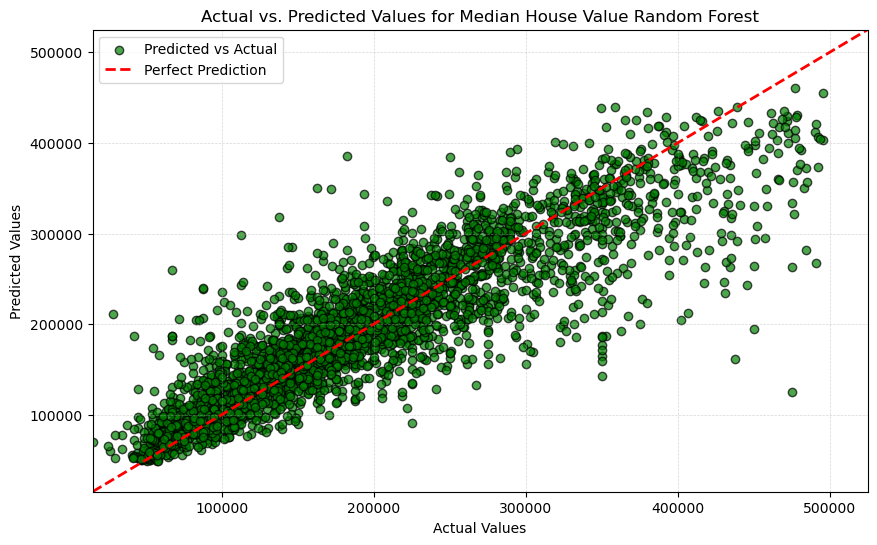

In [37]:
# Predict and evaluate
y_pred_forest = forest.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_forest, alpha=0.7, edgecolor='k', color='green', label='Predicted vs Actual')

# Axis labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Median House Value Random Forest')

# Adjusting the minimum and maximum values for plotting
min_val = max(min(min(y_test), min(y_pred_forest)), 0)
max_val = 525000  # Setting the upper limit as requested

# Axes limits
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

# Perfect prediction line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# Adding a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Legend
plt.legend()

plt.savefig('random_forest_performance.png', dpi=300, bbox_inches='tight')

plt.show()

In [38]:
# Print R2 score
r2_randomforest_regression = forest.score(X_test_scaled, y_test)
print("R2 for Random Forest Regression:", r2_randomforest_regression)
# Calculate MSE between the predicted values and the actual values
mse_randomforest_regression = mean_squared_error(y_test, y_pred_forest)
print("MSE for Random Forest Regression:", mse_randomforest_regression)
# Print RMSE score
rmse_randomforest_regression = np.sqrt(mse_randomforest_regression)
print("RMSE for Random Forest Regression:", rmse_randomforest_regression)
# Print MAE score
mae_randomforest_regression = mean_absolute_error(y_test, y_pred_forest)
print("MAE for Random Forest Regression:", mae_randomforest_regression)

R2 for Random Forest Regression: 0.7974078287167774
MSE for Random Forest Regression: 1860954153.026474
RMSE for Random Forest Regression: 43138.77783417692
MAE for Random Forest Regression: 29191.826146591215


In [39]:
from sklearn.model_selection import RandomizedSearchCV
# Hyperparameter grid
param_grid = {
    'n_estimators': np.arange(100, 1001, 100),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': np.arange(10, 111, 10),  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

In [40]:
# Random Forest model
rf = RandomForestRegressor()

# Randomized search on hyper parameters
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=100, cv=1, verbose=0, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train_scaled, y_train)


InvalidParameterError: The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None. Got 1 instead.

In [ ]:
# Best hyperparameters
print("Best Hyperparameters:", rf_random.best_params_)

# Predicting and evaluating the tuned model
y_pred_rf2 = rf_random.predict(X_test)

# Calculate RMSE
rmse_rf2 = np.sqrt(mean_squared_error(y_test, y_pred_rf2))
print("RMSE:", rmse)


## XGB Model

In [ ]:
import xgboost as xgb

X_train.columns = X_train.columns.str.replace('<', '')
X_test.columns = X_test.columns.str.replace('<', '')

xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=300,
                                learning_rate=0.1,
                                max_depth=10,
                                gamma=1,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                )
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [ ]:
# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7, edgecolor='k', color='pink', label='Predicted vs Actual')

# Axis labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Median House Value XGB')

# Adjusting the minimum and maximum values for plotting
min_val = max(min(min(y_test), min(y_pred_xgb)), 0)
max_val = 525000  # Setting the upper limit as requested

# Axes limits
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

# Perfect prediction line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# Adding a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Legend
plt.legend()

plt.savefig('xgb_model_performance.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = math.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = xgb_model.score(X_test_scaled, y_test)

print("XGB MSE score:", mse_xgb)
print("XGB RMSE score:", rmse_xgb)
print("XGB MAE score:", mae_xgb)
print("XGB R squared score:", r2_xgb)

In [ ]:
## XGB Fine Tuning

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb_model_2 = XGBRegressor(
    gamma=0.38,
    learning_rate=0.15,
    max_depth=4,
    colsample_bytre=0.5,
    n_estimators=1000,
    eval_metric= 'rmse',
    objective='reg:squarederror',
    subsample=0.8,
    reg_alpha=36,
    reg_lambda=33,
    verbosity=0)

xgb_model_2.fit(X_train_scaled, y_train)
y_pred_xgb2 = xgb_model_2.predict(X_test_scaled)

mse_xgb_2 = mean_squared_error(y_test, y_pred_xgb2)
rmse_xgb_2 = math.sqrt(mean_squared_error(y_test, y_pred_xgb2))
mae_xgb_2 = mean_absolute_error(y_test, y_pred_xgb2)
r2_xgb_2 = xgb_model_2.score(X_test_scaled, y_test)

print("XGB MSE score:", mse_xgb_2)
print("XGB RMSE score:", rmse_xgb_2)
print("XGB MAE score:", mae_xgb_2)
print("XGB R squared score:", r2_xgb_2)

# 4. Performance Evaluation

In [ ]:
import matplotlib.image as mpimg

# Filepaths to the saved figures
linear_regression_fig = 'linear_regression_performance.png'
random_forest_fig = 'random_forest_performance.png'
xgboost_fig = 'xgb_model_performance.png'

# Load the images
img_lr = mpimg.imread(linear_regression_fig)
img_rf = mpimg.imread(random_forest_fig)
img_xgb = mpimg.imread(xgboost_fig)

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display each image on a subplot
axs[0].imshow(img_lr)
axs[0].axis('off')  # Hide axes for cleaner look
axs[0].set_title('Linear Regression')

axs[1].imshow(img_rf)
axs[1].axis('off')
axs[1].set_title('Random Forest Regression')

axs[2].imshow(img_xgb)
axs[2].axis('off')
axs[2].set_title('XGBoost Regression')

plt.tight_layout()
plt.show()

### R Squared score

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Linear Regression', 'Random Forest', 'XGBoost']
r2_values = [r2_linear_regression, r2_randomforest_regression, r2_xgb]

x = np.arange(len(labels))
width = 0.6

plt.figure(figsize=(8, 6))
r2_bars = plt.bar(x, r2_values, width, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', alpha=0.7)

plt.ylabel('R² Score')
plt.title('R² Performance by Model')
plt.xticks(x, labels)
plt.ylim(0, 1)  # R² range is 0 to 1

for bar in r2_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


### RMSE Score

In [ ]:
rmse_values = [rmse_linear_regression, rmse_randomforest_regression, rmse_xgb]

plt.figure(figsize=(8, 6))
rmse_bars = plt.bar(x, rmse_values, width, color=['#7f7f7f', '#bcbd22', '#17becf'], edgecolor='black', alpha=0.7)

plt.ylabel('RMSE Score')
plt.title('RMSE Performance by Model')
plt.xticks(x, labels)

for bar in rmse_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


### MAE Score 

In [ ]:
mae_values = [mae_linear_regression, mae_randomforest_regression, mae_xgb]

plt.figure(figsize=(8, 6))
mae_bars = plt.bar(x, mae_values, width, color=['#d62728', '#2ca02c', '#ff9896'], edgecolor='black', alpha=0.7)

plt.ylabel('MAE Score')
plt.title('MAE Performance by Model')
plt.xticks(x, labels)

for bar in mae_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


### MSE Score

In [ ]:
mse_values = [mse_linear_regression, mse_randomforest_regression, mse_xgb]

plt.figure(figsize=(8, 6))
mse_bars = plt.bar(x, mse_values, width, color=['#9467bd', '#8c564b', '#e377c2'], edgecolor='black', alpha=0.7)

plt.ylabel('MSE Score')
plt.title('MSE Performance by Model')
plt.xticks(x, labels)

for bar in mse_bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


Predictions Comparison

In [ ]:
comparison_df = pd.DataFrame({
    "Actual Values": y_test,
    "LR Predicted Values": y_pred_lr,
    "RF Predicted Values": y_pred_forest,
    "XGB Predicted Values": y_pred_xgb
})

comparison_df